# Question 1
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

In [63]:
def joint_posterior(theta, tau, data, theta0, tau0, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: prior mean for theta
      tau0  : prior precision for theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Likelihood (normal with precision tau)
    likelihood = tau**(n/2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta (normal with precision tau0)
    prior_theta = np.exp(-0.5 * tau0 * (theta - theta0)**2)

    # Prior for tau (Gamma with shape alpha, rate lambda)
    prior_tau = tau**(alpha - 1) * np.exp(-lam * tau)

    # Compute unnormalized posterior
    return likelihood * prior_theta * prior_tau

def metropolis_within_gibbs(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      tau0     : prior precision for theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
      prop_sd_tau   : proposal standard deviation for tau
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)  
    theta_current = np.random.normal(theta0, 1 / np.sqrt(tau0))  

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, tau0, alpha, lam)
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau
        # -------------------------------------------------
        tau_proposed = np.random.exponential(scale = 2)
        
        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, tau0, alpha, lam)
        
        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_proposed)/stats.expon.pdf(tau_current))
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

In [74]:
random.seed(10)
np.random.seed(15)

# Generate synthetic data from Normal(50, 1/25)
true_theta = 50
true_tau = 1/25  # Precision = 1 / Variance
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta0 = 0.0      # Prior mean for theta
tau0   = 0.01     # Prior precision for theta (weak prior)
alpha  = 1.0      # Shape of Gamma prior
lam    = 1.0      # Rate of Gamma prior

#, P_current_theta, P_proposed_theta, P_current_tau, P_proposed_tau, Accept_ratio_theta, Accept_ratio_tau
# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, tau0, alpha, lam, n_iter=10000, burn_in=300, prop_sd_theta=0.8
)

/tmp/ipykernel_52/622059493.py:71: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_theta = p_proposed_theta / p_current_theta
/tmp/ipykernel_52/622059493.py:83: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_proposed)/stats.expon.pdf(tau_current))
/tmp/ipykernel_52/622059493.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_proposed)/stats.expon.pdf(tau_current))


In [75]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau  :", np.mean(tau_samples))

Posterior mean of theta: 49.273197037809545
Posterior mean of tau  : 0.05068609648118727


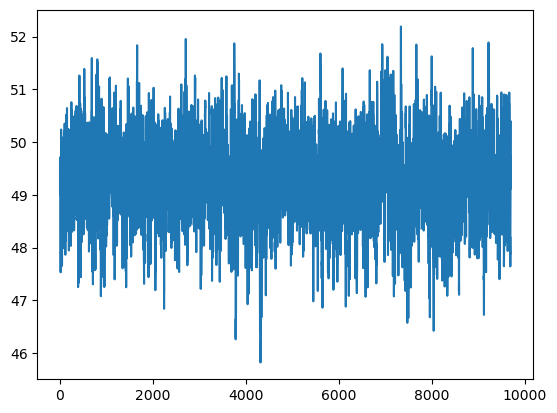

In [76]:
plt.plot(theta_samples)

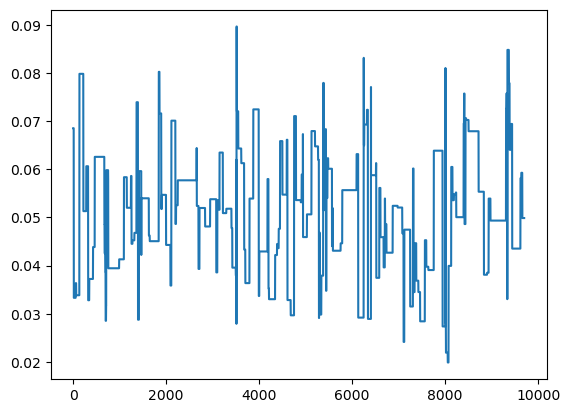

In [77]:
plt.plot(tau_samples)

In [78]:
np.quantile(theta_samples, [0.025, 0.975])

array([47.60106653, 50.85196581])

In [85]:
np.quantile(1/(tau_samples**0.5), [0.025, 0.975])

array([3.71402416, 5.93148979])

Both our credible intervals contain the values assigned to their respective parameters at the beginning of the simulation.

# Question 2
---

In [119]:
def joint_posterior(theta, tau, data, theta0, b, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: prior mean for theta
      b     : scale parameter for Laplace prior on theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Likelihood (normal with precision tau)
    likelihood = tau**(n/2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta (laplace with loc theta0 and scale b)
    prior_theta = np.exp(-np.abs(theta - theta0)/b)

    # Prior for tau (Gamma with shape alpha, rate lambda)
    prior_tau = tau**(alpha - 1) * np.exp(-lam * tau)

    # Compute unnormalized posterior
    return likelihood * prior_theta * prior_tau

def metropolis_within_gibbs(data, theta0, b, alpha, lam, n_iter, burn_in, prop_sd_theta, s):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      b        : scale parameter for Laplace prior on theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
      prop_sd_tau   : proposal standard deviation for tau
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)  
    theta_current = np.random.laplace(theta0, b)  

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, b, alpha, lam)
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau
        # -------------------------------------------------
        tau_proposed = stats.truncnorm.rvs(a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)
        
        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, b, alpha, lam)
        
        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\
                               (stats.truncnorm.pdf(tau_proposed, a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)/\
                                stats.truncnorm.pdf(tau_current, a=-tau_current/s, b=np.inf, loc=tau_current, scale=s))
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

In [166]:

# Generate synthetic data from Normal(50, 1/25)
true_theta = 50
true_tau = 1/25  # Precision = 1 / Variance
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta0 = 0.0      # Prior mean for theta
b      = 10       # Laplace prior scale parameter
alpha  = 1.0      # Shape of Gamma prior
lam    = 1.0      # Rate of Gamma prior

#, P_current_theta, P_proposed_theta, P_current_tau, P_proposed_tau, Accept_ratio_theta, Accept_ratio_tau
# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, b, alpha, lam, n_iter=10000, burn_in=500, prop_sd_theta=1, s = 2
)

/tmp/ipykernel_52/2288924080.py:71: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_theta = p_proposed_theta / p_current_theta
/tmp/ipykernel_52/2288924080.py:83: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\
/tmp/ipykernel_52/2288924080.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\


In [167]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau  :", np.mean(tau_samples))

Posterior mean of theta: 49.782384309543055
Posterior mean of tau  : 0.04102822666933727


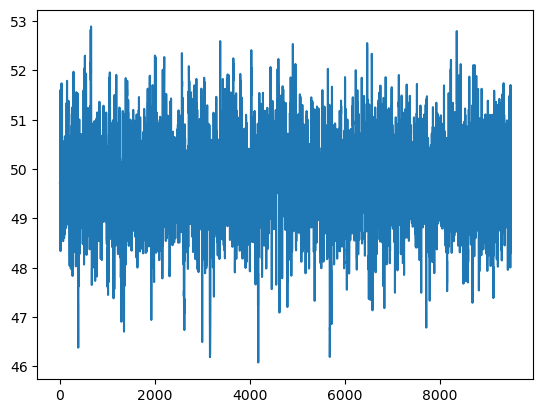

In [168]:
plt.plot(theta_samples)

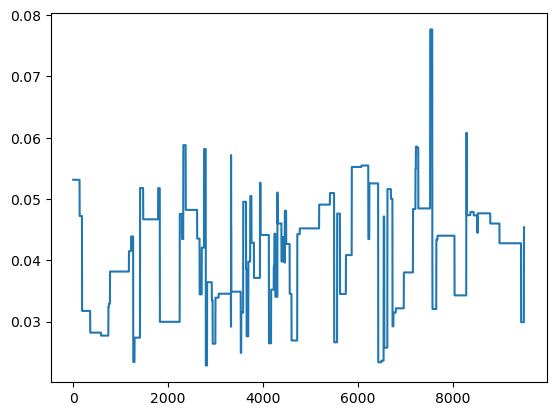

In [169]:
plt.plot(tau_samples)

In [170]:
np.quantile(theta_samples, [0.025, 0.975])

array([47.95623249, 51.63074078])

In [171]:
np.quantile(1/(tau_samples**0.5), [0.025, 0.975])

array([4.24600181, 6.23126815])

# Question 3
---
The ratios involving $q$ cancel because 
$$q(0|1) = \frac 12 = q(1|0)$$
Meanwhile we have
$$\begin{array}{ccc} p(0) = \frac13 & \text{ and } & p(1) = \frac23 \end{array}$$
Since the proposal ratio is symmetric, it cancels so our acceptance probability becomes
$$A(x^{(t-1)}, \tilde x^{(t)}) = \min\left(1, \frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\right)$$
Suppose $x^{(t-1)} = 0$. The proposal $\tilde x^{(t)} = 1$ happens with probability $1/2$, and
$$A(0,1) = \min\left(1, \frac{2/3}{1/3}\right) = \min(1, 2) = 1$$
so the probability of transitioning to $1$ from $0$ is $1/2$. The probability of staying at $0$ is thus $1 - 1/2 = 1/2$. \\
Suppose $x^{(t-1)} = 1$. The proposal $\tilde x^{(t)} = 0$ happens with probability $1/2$, and 
$$A(1,0) = \min\left(1, \frac{1/3}{2/3}\right) = \min(1, 0.5) = 0.5$$
so the probability of transitioning to $0$ from $1$ is $1/4$. The probability of staying at $1$ is thus $1 - 1/4 = 3/4$. We conclude that 
$$K = \begin{pmatrix} 0.5 & 0.25 \\ 0.5 & 0.75 \end{pmatrix}$$
as desired. 